# Question

What's going on with the drone exports from Latvia to Ukraine?

# Data source

CSP data on imported/exported goods:
https://data.stat.gov.lv/pxweb/lv/OSP_PUB/START__TIR__AT__ATD/ATD040m/ (monthly)
https://data.stat.gov.lv/pxweb/lv/OSP_PUB/START__TIR__AT__ATD/ATD040/ (annual)

We are interested in the Combined Nomenclature code 8806 (Bezpilota gaisa kuģi). Source: https://e.csb.gov.lv/HelpDesk/lv/SubCategory/342


In [1]:
from pycspwrapper import LVStat

In [2]:
stat = LVStat('lv', 'TIR','AT','ATD','ATD040m')
stat.set_query(
    CN4Z=["8806"], # droni
    FLOW=["EXP"],
    COUNTRY=["TOTAL", "UA"],
)
export_data_json = stat.get_data()
export_data_json

{'columns': [{'code': 'FLOW', 'text': 'Plūsma', 'type': 'd'},
  {'code': 'CN4Z', 'text': 'Kombinētā nomenklatūra (KN 4 zīmēs)', 'type': 'd'},
  {'code': 'COUNTRY', 'text': 'Valstis', 'type': 'd'},
  {'code': 'TIME', 'text': 'Laika periods', 'type': 't'},
  {'code': 'ATD040m', 'text': 'Vērtība (Eiro)', 'type': 'c'},
  {'code': 'ATD040m1', 'text': 'Svars, Kg', 'type': 'c'}],
 'comments': [],
 'data': [{'key': ['EXP', '8806', 'TOTAL', '2005M01'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'TOTAL', '2005M02'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'TOTAL', '2005M03'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'TOTAL', '2005M04'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'TOTAL', '2005M05'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'TOTAL', '2005M06'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'TOTAL', '2005M07'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'TOTAL', '2005M08'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'TOTAL', '200

In [3]:
# Let's convert the data to a dataframe so we can work with it.
import polars as pl
from datetime import date

def data_to_df(data):
    '''Transform the data returned by CSP API into a dataframe.'''
    key_cols = []
    val_cols = []
    column_values = {}
    for col in data['columns']:
        if col['type'] == 'c':
            val_cols.append(col['code'])
        else:
            key_cols.append(col['code'])
        column_values[col['code']] = []
    for row in data['data']:
        for col, value in zip(key_cols, row['key']):
            if col == "TIME":
                # Transform time values to date.
                if len(value) == 4:
                    value = date(int(value), 1, 1)
                elif value[4] == 'M':
                    split_time = value.split('M', 1)
                    value = date(int(split_time[0]), int(split_time[1]), 1)
            column_values[col].append(value)
        for col, value in zip(val_cols, row['values']):
            if value == '…':
                # Missing value.
                column_values[col].append(None)
            else:
                column_values[col].append(float(value))
    series = map(
        lambda kv: pl.Series(kv[0], kv[1]),
        column_values.items()
    )
    return pl.DataFrame(series)

export_data = data_to_df(export_data_json)

export_data

FLOW,CN4Z,COUNTRY,TIME,ATD040m,ATD040m1
str,str,str,date,f64,f64
"""EXP""","""8806""","""TOTAL""",2005-01-01,0.0,0.0
"""EXP""","""8806""","""TOTAL""",2005-02-01,0.0,0.0
"""EXP""","""8806""","""TOTAL""",2005-03-01,0.0,0.0
"""EXP""","""8806""","""TOTAL""",2005-04-01,0.0,0.0
"""EXP""","""8806""","""TOTAL""",2005-05-01,0.0,0.0
…,…,…,…,…,…
"""EXP""","""8806""","""UA""",2023-09-01,149700.0,233.0
"""EXP""","""8806""","""UA""",2023-10-01,16827.0,5.0
"""EXP""","""8806""","""UA""",2023-11-01,10471.0,10.0


In [4]:
# Transform the data so we can work with total and UA data alongside.
total_exports = export_data.filter(
    pl.col('COUNTRY') == 'TOTAL',
    pl.col('TIME') >= date(2022, 1, 1)
).select(
    pl.col('TIME'),
    (pl.col('ATD040m') / 1000000).alias('TOTAL')
)

ua_exports = export_data.filter(
    pl.col('COUNTRY') == 'UA',
    pl.col('TIME') >= date(2022, 1, 1)
).select(
    pl.col('TIME'),
    (pl.col('ATD040m') / 1000000).alias('UA')
)

total_exports = total_exports.join(
    ua_exports,
    on='TIME',
    how='left'
).with_columns(
    (pl.col('UA') / pl.col('TOTAL')).alias('UA_share')
)
total_exports

TIME,TOTAL,UA,UA_share
date,f64,f64,f64
2022-01-01,0.604669,0.0,0.0
2022-02-01,0.304235,0.0,0.0
2022-03-01,0.365717,0.0,0.0
2022-04-01,1.058872,0.544056,0.513807
2022-05-01,1.800064,1.275113,0.708371
…,…,…,…
2023-09-01,3.530228,0.1497,0.042405
2023-10-01,3.987166,0.016827,0.00422
2023-11-01,2.959237,0.010471,0.003538


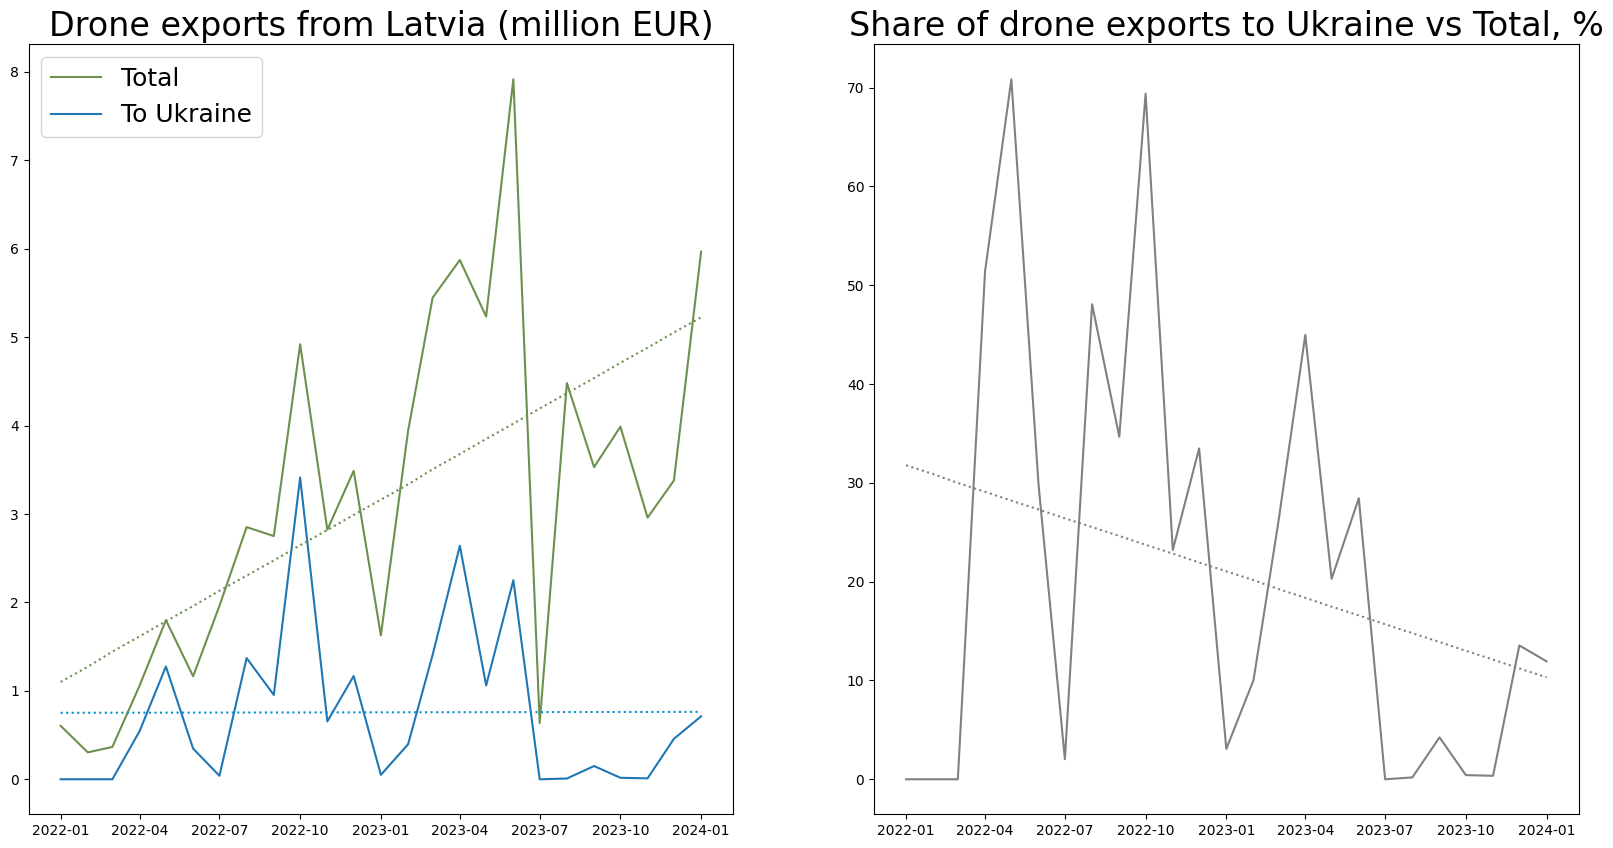

In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].set_title('Drone exports from Latvia (million EUR)', fontsize=24)
ax[1].set_title('Share of drone exports to Ukraine vs Total, %', fontsize=24)

ax[0].plot(
    total_exports['TIME'],
    total_exports['TOTAL'],
    label='Total',
    color="#6d904f"
)
ax[0].plot(
    total_exports['TIME'],
    total_exports['UA'],
    label='To Ukraine',
)
ax[0].legend(loc='upper left', fontsize=18)

# Linear regression for total
x = range(0, len(total_exports))
total_trend = np.polyfit(x, total_exports['TOTAL'], 1)
p = np.poly1d(total_trend)
ax[0].plot(
    total_exports['TIME'],
    p(x),
    color="#6d904f",
    ls=':'
)

ua_trend = np.polyfit(x, total_exports['UA'], 1)
p = np.poly1d(ua_trend)
ax[0].plot(
    total_exports['TIME'],
    p(x),
    color="#008fd5",
    ls=':'
)


ax[1].plot(
    total_exports['TIME'],
    total_exports['UA_share']*100,
    color="gray"
)
ua_trend = np.polyfit(x, total_exports['UA_share']*100, 1)
p = np.poly1d(ua_trend)
ax[1].plot(
    total_exports['TIME'],
    p(x),
    color="gray",
    ls=':'
)

plt.show()

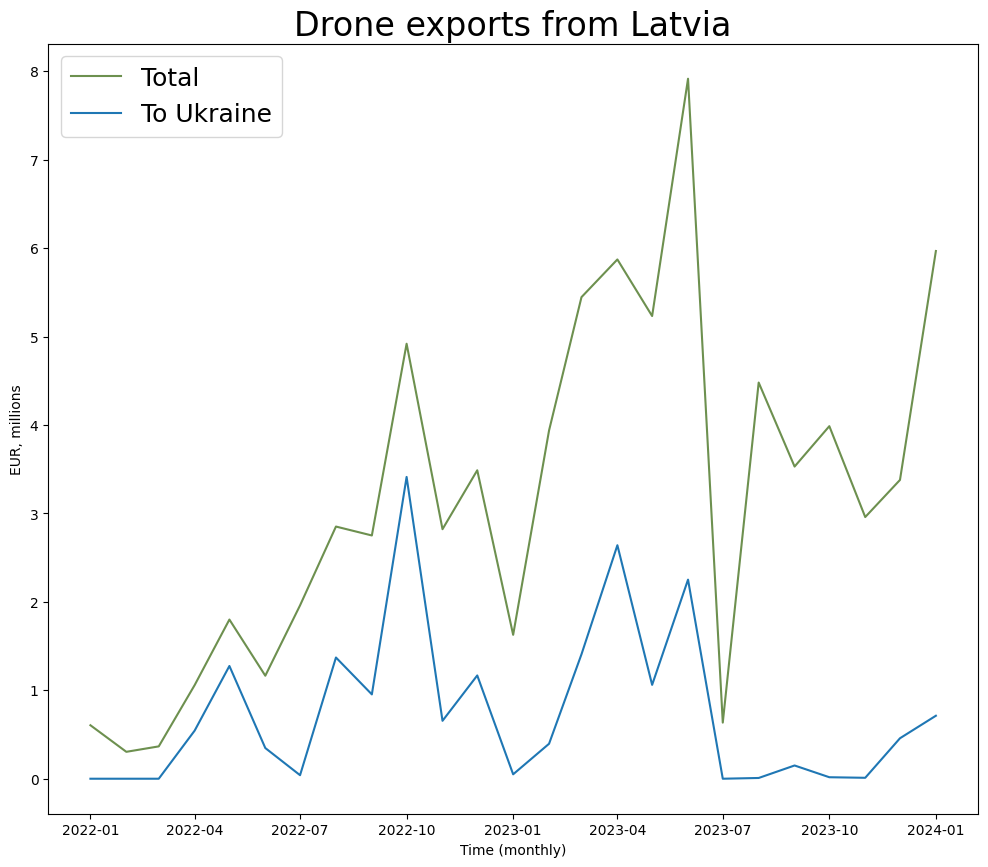

In [6]:

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.set_title('Drone exports from Latvia', fontsize=24)

ax.plot(
    total_exports['TIME'],
    total_exports['TOTAL'],
    label='Total',
    color="#6d904f"
)
ax.plot(
    total_exports['TIME'],
    total_exports['UA'],
    label='To Ukraine',
)
ax.legend(loc='upper left', fontsize=18)

ax.set_xlabel('Time (monthly)')
ax.set_ylabel('EUR, millions')


plt.show()

In [7]:
# Calculate annual totals.
exports_2022 = total_exports.filter(
    pl.col('TIME') >= date(2022, 1, 1),
    pl.col('TIME') < date(2023, 1, 1)
).sum().with_columns(
    (pl.col('UA') / pl.col('TOTAL')).alias('UA_share'),
    pl.lit(2022).alias('TIME')
)
exports_2023 = total_exports.filter(
    pl.col('TIME') >= date(2023, 1, 1),
    pl.col('TIME') < date(2024, 1, 1)
).sum().with_columns(
    (pl.col('UA') / pl.col('TOTAL')).alias('UA_share'),
    pl.lit(2023).alias('TIME')
)
pl.concat([exports_2022, exports_2023], how='vertical')

TIME,TOTAL,UA,UA_share
i32,f64,f64,f64
2022,24.091315,9.766317,0.405387
2023,49.004381,8.449404,0.172421


Where did the rest of exports in 2023 go? Let's look at the annual data by country.


In [8]:
stat = LVStat('lv', 'TIR','AT','ATD','ATD040')
stat.set_query(
    CN4Z=["8806"], # droni
    FLOW=["EXP"],
    TIME=["2023"],
    COUNTRY=stat.get_variables()["COUNTRY"]
)
export_data_json = stat.get_data()
export_data_json

{'columns': [{'code': 'FLOW', 'text': 'Plūsma', 'type': 'd'},
  {'code': 'CN4Z', 'text': 'Kombinētā nomenklatūra (KN 4 zīmēs)', 'type': 'd'},
  {'code': 'COUNTRY', 'text': 'Valstis', 'type': 'd'},
  {'code': 'TIME',
   'text': 'Laika periods',
   'comment': 'Provizoriski dati.\r\n',
   'type': 't'},
  {'code': 'ATD040', 'text': 'Vērtība (Eiro)', 'type': 'c'},
  {'code': 'ATD0401', 'text': 'Svars, Kg', 'type': 'c'}],
 'comments': [{'variable': 'COUNTRY',
   'value': 'HR',
   'comment': 'ES dalībvalsts no 01.07.2013\r\n'}],
 'data': [{'key': ['EXP', '8806', 'TOTAL', '2023'],
   'values': ['49004381', '98266']},
  {'key': ['EXP', '8806', 'AD', '2023'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'AE', '2023'], 'values': ['650068', '1597']},
  {'key': ['EXP', '8806', 'AF', '2023'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'AG', '2023'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'AI', '2023'], 'values': ['0', '0']},
  {'key': ['EXP', '8806', 'AL', '2023'], 'values': ['0'

In [9]:
country_export = data_to_df(
    export_data_json
).select(
    (pl.col('ATD040') / 1000000).alias('AMOUNT'),
).filter(
    pl.col('COUNTRY') != 'TOTAL'
)
country_export.sort(pl.col('AMOUNT'), descending=True).head(10)

AMOUNT,COUNTRY
f64,str
2.0507956e7,"""CZ"""
8.449404e6,"""UA"""
6.02739e6,"""LT"""
4.632826e6,"""EE"""
2.53849e6,"""PL"""
1.567485e6,"""NL"""
1.016568e6,"""US"""
760384.0,"""GE"""
650068.0,"""AE"""


Let's see the export dynamics to Czech Republic.

In [108]:
stat = LVStat('lv', 'TIR','AT','ATD','ATD040m')
stat.set_query(
    CN4Z=["8806"], # droni
    FLOW=["EXP"],
    COUNTRY=["TOTAL", "CZ"],
)
export_data_json = stat.get_data()
export_data = data_to_df(export_data_json)
export_data

FLOW,CN4Z,COUNTRY,TIME,ATD040m,ATD040m1
str,str,str,date,f64,f64
"""EXP""","""8806""","""TOTAL""",2005-01-01,0.0,0.0
"""EXP""","""8806""","""TOTAL""",2005-02-01,0.0,0.0
"""EXP""","""8806""","""TOTAL""",2005-03-01,0.0,0.0
"""EXP""","""8806""","""TOTAL""",2005-04-01,0.0,0.0
"""EXP""","""8806""","""TOTAL""",2005-05-01,0.0,0.0
…,…,…,…,…,…
"""EXP""","""8806""","""CZ""",2023-09-01,1.323255e6,5491.0
"""EXP""","""8806""","""CZ""",2023-10-01,1.926347e6,8244.0
"""EXP""","""8806""","""CZ""",2023-11-01,793658.0,3394.0


In [109]:

# Transform the data so we can work with total and UA data alongside.
total_exports = export_data.filter(
    pl.col('COUNTRY') == 'TOTAL',
    pl.col('TIME') >= date(2022, 1, 1)
).select(
    pl.col('TIME'),
    (pl.col('ATD040m') / 1000000).alias('TOTAL')
)

cz_exports = export_data.filter(
    pl.col('COUNTRY') == 'CZ',
    pl.col('TIME') >= date(2022, 1, 1)
).select(
    pl.col('TIME'),
    (pl.col('ATD040m') / 1000000).alias('CZ')
)

total_exports = total_exports.join(
    cz_exports,
    on='TIME',
    how='left'
).with_columns(
    (pl.col('CZ') / pl.col('TOTAL')).alias('CZ_share')
)
total_exports

TIME,TOTAL,CZ,CZ_share
date,f64,f64,f64
2022-01-01,0.604669,0.0,0.0
2022-02-01,0.304235,0.0,0.0
2022-03-01,0.365717,0.005652,0.015455
2022-04-01,1.058872,0.0,0.0
2022-05-01,1.800064,0.0,0.0
…,…,…,…
2023-09-01,3.530228,1.323255,0.374836
2023-10-01,3.987166,1.926347,0.483137
2023-11-01,2.959237,0.793658,0.268197


In [110]:
# CZ share in 2023
total_exports.filter(
    pl.col('TIME') >= date(2023, 1, 1),
    pl.col('TIME') < date(2024, 1, 1)
).sum().with_columns(
    (pl.col('CZ')/pl.col('TOTAL')).alias('CZ_share'))

TIME,TOTAL,CZ,CZ_share
date,f64,f64,f64
null,49.004381,20.507956,0.418492


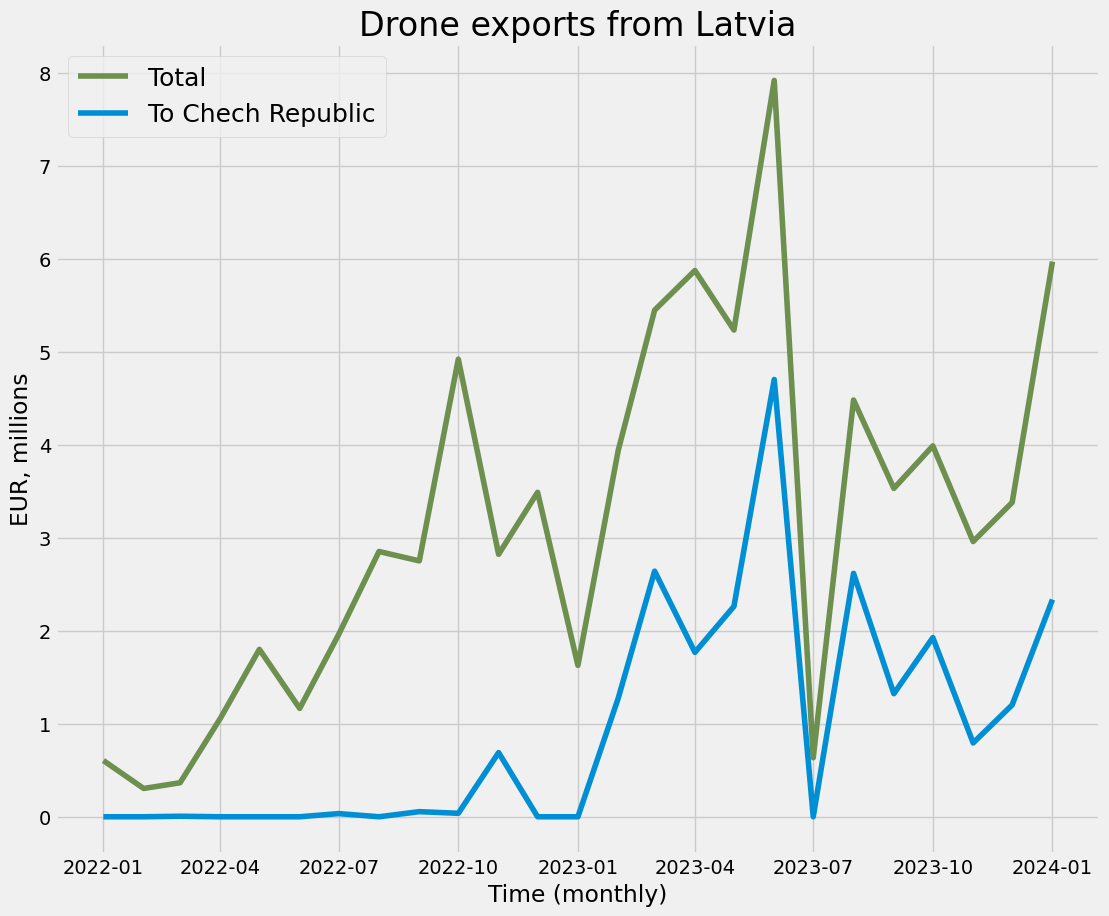

In [111]:

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.set_title('Drone exports from Latvia', fontsize=24)

ax.plot(
    total_exports['TIME'],
    total_exports['TOTAL'],
    label='Total',
    color="#6d904f"
)
ax.plot(
    total_exports['TIME'],
    total_exports['CZ'],
    label='To Chech Republic',
)
ax.legend(loc='upper left', fontsize=18)

ax.set_xlabel('Time (monthly)')
ax.set_ylabel('EUR, millions')


plt.show()